# Tabular Baseline Models for Property Price Prediction

This notebook establishes strong tabular baselines for property price prediction
using structured housing attributes. The purpose is to quantify how much predictive
power can be achieved without visual data and to provide a benchmark for later
multimodal modeling.

## 1. Loading Training and Test Datasets

We load the raw training and test datasets containing structured property attributes.
The training data includes the target variable (`price`), while the test data is used
only for inference.

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv("../data/raw/train.csv")
test  = pd.read_csv("../data/raw/test.csv")

print(train.shape, test.shape)
train.head()

(16209, 21) (5404, 20)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071


Both datasets share the same feature schema, ensuring consistent preprocessing
between training and inference.

## 2. Dataset Overview

We inspect data types, feature distributions, and summary statistics to ensure
all features are numeric and suitable for regression modeling.

In [2]:
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16209 entries, 0 to 16208
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             16209 non-null  int64  
 1   date           16209 non-null  object 
 2   price          16209 non-null  int64  
 3   bedrooms       16209 non-null  int64  
 4   bathrooms      16209 non-null  float64
 5   sqft_living    16209 non-null  int64  
 6   sqft_lot       16209 non-null  int64  
 7   floors         16209 non-null  float64
 8   waterfront     16209 non-null  int64  
 9   view           16209 non-null  int64  
 10  condition      16209 non-null  int64  
 11  grade          16209 non-null  int64  
 12  sqft_above     16209 non-null  int64  
 13  sqft_basement  16209 non-null  int64  
 14  yr_built       16209 non-null  int64  
 15  yr_renovated   16209 non-null  int64  
 16  zipcode        16209 non-null  int64  
 17  lat            16209 non-null  float64
 18  long  

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.620900e+04,1.620900e+04,16209.00000,16209.000000,16209.000000,1.620900e+04,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000
mean,4.575771e+09,5.374703e+05,3.36782,2.113054,2073.274601,1.486767e+04,1.498828,0.006971,0.234253,3.407860,7.652971,1784.754396,288.520205,1971.152755,82.738108,98077.974767,47.560707,-122.214003,1983.152261,12735.572707
std,2.874661e+09,3.603036e+05,0.93327,0.765242,907.009491,3.882570e+04,0.543032,0.083206,0.763152,0.651553,1.171050,821.820844,438.598910,29.372698,397.861148,53.355282,0.138340,0.140093,681.905161,26933.162012
min,1.000102e+06,7.500000e+04,0.00000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.159300,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.200000e+05,3.00000,1.500000,1430.000000,5.004000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1952.000000,0.000000,98033.000000,47.472500,-122.328000,1480.000000,5098.000000
50%,3.904950e+09,4.500000e+05,3.00000,2.250000,1910.000000,7.599000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.572400,-122.230000,1840.000000,7620.000000
75%,7.304301e+09,6.400000e+05,4.00000,2.500000,2550.000000,1.063100e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2200.000000,560.000000,1997.000000,0.000000,98117.000000,47.678200,-122.125000,2360.000000,10053.000000
max,9.900000e+09,7.700000e+06,33.00000,8.000000,12050.000000,1.164794e+06,3.500000,1.000000,4.000000,5.000000,13.000000,8860.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


## 3. Defining Features and Target Variable

The goal is to predict the continuous target variable `price` using structured
housing attributes.

In [3]:
TARGET = "price"

We remove identifier and timestamp columns that do not carry predictive value.
The remaining columns are used as model inputs.

In [4]:
DROP_COLS = ["id", "price", "date"]

X = train.drop(columns=DROP_COLS)
y = train["price"]

X_test = test.drop(columns=["id", "date"])

## 4. Train–Validation Split

The dataset is split into training and validation sets to evaluate model performance
on unseen data.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 5. Feature Scaling for Linear Models

Standardization is applied to the feature set to ensure that linear regression
is not biased by feature scale. Tree-based models will later be trained on
unscaled data.

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

## 6. Baseline Model: Linear Regression

We first train a linear regression model to establish a simple baseline.
This provides a lower bound on expected performance.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

val_preds = lr.predict(X_val_scaled)

mse  = mean_squared_error(y_val, val_preds)
rmse = np.sqrt(mse)
r2   = r2_score(y_val, val_preds)

print(f"Linear Regression RMSE: {rmse:.2f}")
print(f"Linear Regression R²  : {r2:.4f}")

Linear Regression RMSE: 191661.41
Linear Regression R²  : 0.7073


The linear regression model captures only linear relationships and achieves
moderate performance. This highlights the presence of non linear interactions
among features, motivating the use of more expressive models.

## 7. Strong Tabular Model: XGBoost Regressor

XGBoost is well suited for tabular data due to its ability to capture
non linear feature interactions and handle multicollinearity.

In [8]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)

val_preds = xgb.predict(X_val)

mse  = mean_squared_error(y_val, val_preds)
rmse = np.sqrt(mse)
r2   = r2_score(y_val, val_preds)

print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost R²  : {r2:.4f}")

XGBoost RMSE: 117577.95
XGBoost R²  : 0.8898


The XGBoost model significantly outperforms linear regression, achieving a
high R² score. This establishes a strong tabular baseline that later multimodal
models must surpass to justify added complexity.

## 8. Feature Importance Analysis

To interpret the tabular model, we examine feature importances learned by XGBoost.
This helps identify which structured attributes most strongly influence predictions.

In [9]:
import matplotlib.pyplot as plt

importances = xgb.feature_importances_
features = X.columns

imp_df = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

imp_df.head(10)

,feature,importance
8,grade,0.413609
5,waterfront,0.146020
2,sqft_living,0.115624
14,lat,0.069130
6,view,0.051598
1,bathrooms,0.034673
15,long,0.034504
16,sqft_living15,0.024082
11,yr_built,0.019240
9,sqft_above,0.018886


The following visualization highlights the most influential tabular features
used by the XGBoost model.

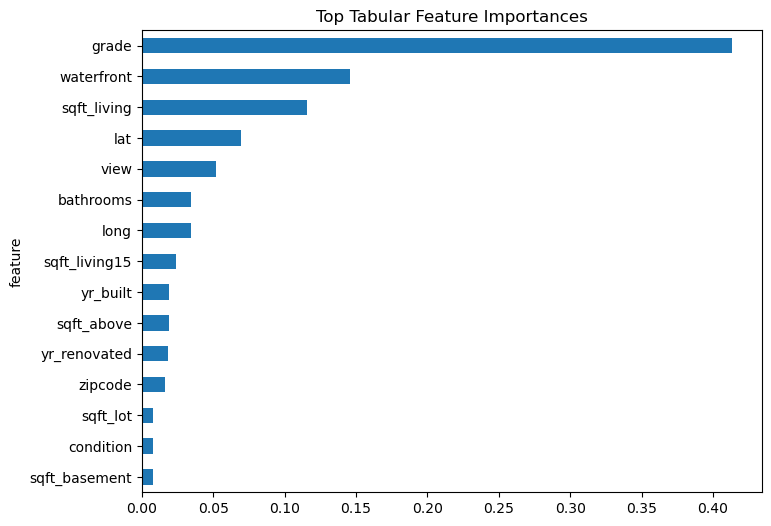

In [10]:
imp_df.head(15).plot(
    kind="barh",
    x="feature",
    y="importance",
    figsize=(8,6),
    legend=False
)
plt.gca().invert_yaxis()
plt.title("Top Tabular Feature Importances")
plt.show()

### Interpretation

- **Construction grade** is the most influential feature, reflecting build quality
  and architectural design.
- **Waterfront presence** introduces a strong price premium.
- **Living area** and **geographic coordinates** play a significant role.
- Neighborhood related and environmental features are highly predictive, suggesting
  that visual context from satellite imagery may provide complementary information.

These insights motivate the exploration of multimodal models that incorporate
satellite imagery to capture neighborhood-level cues not fully represented
by structured attributes.

### Summary

This notebook establishes a strong tabular baseline using XGBoost, achieving
high predictive performance on property prices. Feature importance analysis
reveals that location, quality, and environmental factors are key drivers,
providing a clear motivation for integrating satellite imagery in subsequent
multimodal modeling.